In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
import ulmo
#from pandas.stats.api import ols #HELP TODO
from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

In [3]:
import logging
logging.basicConfig()
logger = logging.getLogger('ulmo.usgs.nwis.core')
logger.setLevel(logging.WARNING)

In [5]:
import rpy2

In [15]:
def importusgssite(siteno):
    sitename = {}
    sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", period="all")
    sitename = pd.DataFrame(sitename['00060:00003']['values'])
    sitename['dates'] = pd.to_datetime(pd.Series(sitename['datetime']))
    sitename.set_index(['dates'],inplace=True)
    sitename[siteno] = sitename['value'].astype(float)
    sitename[str(siteno)+'qual'] = sitename['qualifiers']
    sitename = sitename.drop(['datetime','qualifiers','value'],axis=1)
    sitename = sitename.replace('-999999',np.NAN)
    sitename = sitename.dropna()
    #sitename['mon']=sitename.index.month
    return sitename

In [16]:
def getusgssiteinfo(siteno):
    siteinfo = ulmo.usgs.nwis.get_site_data(siteno, service="daily", period="all")
    siteinfo = pd.DataFrame(siteinfo['00060:00003']['site'])
    siteinfo['latitude'] = siteinfo.loc['latitude','location']
    siteinfo['longitude'] = siteinfo.loc['longitude','location']
    siteinfo['latitude'] = siteinfo['latitude'].astype(float)
    siteinfo['longitude'] = siteinfo['longitude'].astype(float)
    siteinfo = siteinfo.drop(['default_tz','dst_tz','srs','uses_dst','longitude'],axis=0)
    siteinfo = siteinfo.drop(['agency','timezone_info','location','state_code','network'],axis=1)
    return siteinfo

In [17]:
sites = ['09309600','09309800',
         '09310000','09310500','09310700','09311500','09312700','09313000',
         '09317000','09317919','09317920','09317997','09318000','09318500','09319000',
         '09323000','09324000','09324200','09324500','09325000','09325100','09326500','09327500','09327550',
         '09330500','09331900','09331950','09332100',
         '10148500',
         '10205030','10206000','10206001','10208500',
         '10210000','10211000','10215700','10215900','10216210','10216400','10217000']
sitelab = ['Q'+site for site in sites]
print(len(sites))

40


In [18]:
d = {}
for site in sites:
    #print site #use this line to error check site numbers
    d[site] = importusgssite(site);
    f = {}
f[sites[0]] = d[sites[0]]
for i in range(len(sites)-1):
    f[sites[i+1]] = pd.merge(d[sites[i+1]], f[sites[i]], left_index=True, right_index=True, how='outer')

KeyError: '00045:00003'

In [10]:
USGS_Site_Data = f[sites[-1]]
USGS_Site_Data['mon'] = USGS_Site_Data.index.month
USGS_Site_Data['yr'] = USGS_Site_Data.index.year
USGS_Site_Data['dy'] = USGS_Site_Data.index.dayofyear

In [12]:
USGS_Site_Data.to_csv('USGS_Site_Data.csv')

In [11]:
z = {}
for site in sites:
    z[site] = getusgssiteinfo(site);

In [13]:
z
cek = pd.concat(z)

In [14]:
z

{'09309600':               code                               name county       huc  \
 latitude  09309600  FAIRVIEW TUNNEL NEAR FAIRVIEW, UT  49039  14060007   
 
          site_type   latitude   longitude  
 latitude        ST  39.667462 -111.312124  ,
 '09309800':               code                                  name county       huc  \
 latitude  09309800  GOOSEBERRY CREEK NEAR FAIRVIEW, UTAH  49039  14060007   
 
          site_type   latitude   longitude  
 latitude        ST  39.674129 -111.304901  ,
 '09310000':               code                                name county       huc  \
 latitude  09310000  GOOSEBERRY CREEK NEAR SCOFIELD, UT  49039  14060007   
 
          site_type   latitude   longitude  
 latitude        ST  39.715795 -111.300179  ,
 '09310500':               code                                           name county  \
 latitude  09310500  FISH CREEK ABOVE RESERVOIR, NEAR SCOFIELD, UT  49007   
 
                huc site_type   latitude   longitude  
 lat

In [14]:
USGS_Site_Info = pd.concat(z)
USGS_Site_Info = USGS_Site_Info.reset_index()
USGS_Site_Info = USGS_Site_Info.drop(['level_1'],axis=1)
USGS_Site_Info = USGS_Site_Info.set_index(['level_0'])
USGS_Site_Info = USGS_Site_Info.drop(['code'],axis=1)


In [15]:
q = {}
m = {}
for site in sites:
    q[site] = USGS_Site_Data[site].first_valid_index()
    m[site] = USGS_Site_Data[site].last_valid_index()

USGS_start_date = pd.DataFrame(data=q, index=[0])
USGS_finish_date = pd.DataFrame(data=m, index=[0])
USGS_start_date = USGS_start_date.transpose()
USGS_start_date['start_date'] = USGS_start_date[0]
USGS_start_date = USGS_start_date.drop([0],axis=1)
USGS_finish_date = USGS_finish_date.transpose()
USGS_finish_date['fin_date'] = USGS_finish_date[0]
USGS_finish_date = USGS_finish_date.drop([0],axis=1)
USGS_start_fin = pd.merge(USGS_finish_date,USGS_start_date, left_index=True, right_index=True, how='outer' )
USGS_Site_Info = pd.merge(USGS_start_fin,USGS_Site_Info, left_index=True, right_index=True, how='outer' )
USGS_sum_stats = USGS_Site_Data[sites].describe()
USGS_sum_stats = USGS_sum_stats.transpose()
USGS_Site_Info = pd.merge(USGS_sum_stats,USGS_Site_Info, left_index=True, right_index=True, how='outer' )

<Figure size 576x720 with 0 Axes>

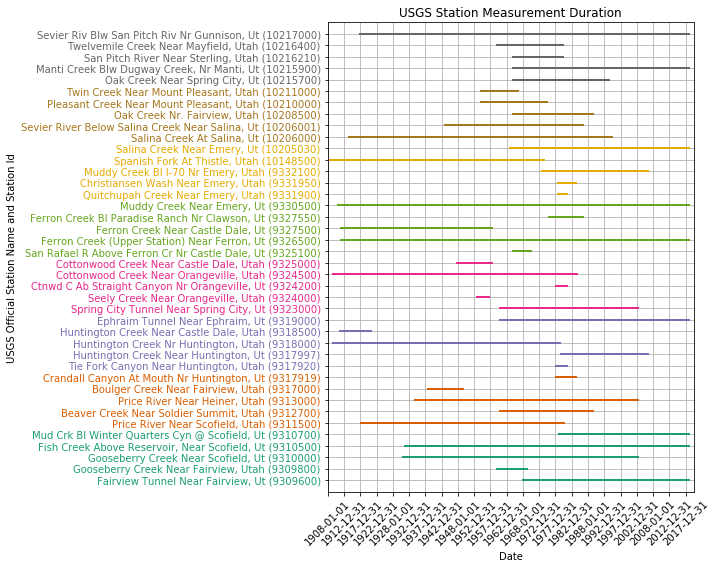

In [16]:
# designate variables
x2 = USGS_Site_Info['fin_date'].astype(datetime).values
x1 = USGS_Site_Info['start_date'].astype(datetime).values
y = USGS_Site_Info.index.astype(np.int)
names = USGS_Site_Info['name'].values

labs, tickloc, col = [], [], []

# create color iterator for multi-color lines in gantt chart
color=iter(cm.Dark2(np.linspace(0,1,len(y))))

plt.figure(figsize=[8,10])
fig, ax = plt.subplots()

# generate a line and line properties for each station
for i in range(len(y)):
    c=next(color)
    
    plt.hlines(i+1, x1[i], x2[i], label=y[i], color=c, linewidth=2)
    labs.append(names[i].title()+" ("+str(y[i])+")")
    tickloc.append(i+1)
    col.append(c)
plt.ylim(0,len(y)+1)
plt.yticks(tickloc, labs)

# create custom x labels
plt.xticks(np.arange(datetime(np.min(x1).year,1,1),np.max(x2)+timedelta(days=365.25),timedelta(days=365.25*5)),rotation=45)
plt.xlim(datetime(np.min(x1).year,1,1),np.max(x2)+timedelta(days=365.25))
plt.xlabel('Date')
plt.ylabel('USGS Official Station Name and Station Id')
plt.grid()
plt.title('USGS Station Measurement Duration')
# color y labels to match lines
gytl = plt.gca().get_yticklabels()
for i in range(len(gytl)):
    gytl[i].set_color(col[i])
plt.tight_layout()

plt.savefig('gantt.pdf');

In [18]:
# create dictionary of integers and their month equivalent
months = {'1':'Jan.', '2':'Feb.', '3':'Mar.', '4':'Apr.', '5':'May', '6':'Jun.', 
         '7':'Jul.', '8':'Aug.', '9':'Sep.', '10':'Oct.', '11':'Nov.', '12':'Dec.', 'Total':'Total'}
# create empty dictionary to hold pandas Dataframes
j = {}


with PdfPages('station_boxplots.pdf') as pdfs:
    ymax = 10000
    ymin = 0.01
    for i in range(len(sites)):
        # make a dataframe containing summary statistics and store it in the j dictionary
        j[sites[i]] = USGS_Site_Data.groupby('mon')[sites[i]].agg({'min':np.min, 'mean':np.mean, 
                                                                   'median':np.median, 'max':np.max, 'std':np.std, 
                                                                   'cnt':(lambda x: np.count_nonzero(~np.isnan(x)))}).reset_index()
        # make a list of the custom lables you will use for your boxplot; this one will show the number of samples used to make the plot
        labs = [months[(str(j[sites[i]]['mon'][b]))] + " (n=" + str(int(j[sites[i]]['cnt'][b])) + ")" for b in range(len(j[sites[i]]))]
        # designate the location of each custom label
        tickloc = [b+1 for b in range(len(j[sites[i]]['mon']))]
        
        plt.figure()
        USGS_Site_Data.boxplot(column=sites[i],by='mon', rot=70)
        strtdt = str(USGS_Site_Info.ix[sites[i],'start_date'])[0:10]
        findt = str(USGS_Site_Info.ix[sites[i],'fin_date'])[0:10]
        siteName = USGS_Site_Info.ix[sites[i],'name'].title() 
        plt.title( siteName + ' (' + sites[i] + ')  ' + strtdt + ' to ' + findt )
        plt.suptitle('')
        plt.yscale('log')
        plt.ylabel('Discharge (cfs)')
        plt.ylim((ymin,ymax))
        plt.xlabel('Month')
        # here is where your lists for the custom label come into play
        plt.xticks(tickloc, labs)
        
        pdfs.savefig()

        plt.close()
    # Save metadata of the pdf so you can find it later
    d = pdfs.infodict()
    d['Title'] = 'Monthly Station USGS Boxplots UMSS'
    d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
    d['Subject'] = 'Boxplots of several USGS Surface Stations'
    d['Keywords'] = 'USGS Surface NWIS Boxplot'
    d['CreationDate'] = datetime.today()
    d['ModDate'] = datetime.today()

/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/aroja164/.l

/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/aroja164/anaconda3/envs/flood02/lib/python3.6/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/home/aroja164/.local/lib/python3

/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/aroja164/anaconda3/envs/flood02/lib/python3.6/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/home/aroja164/.local/lib/python3

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

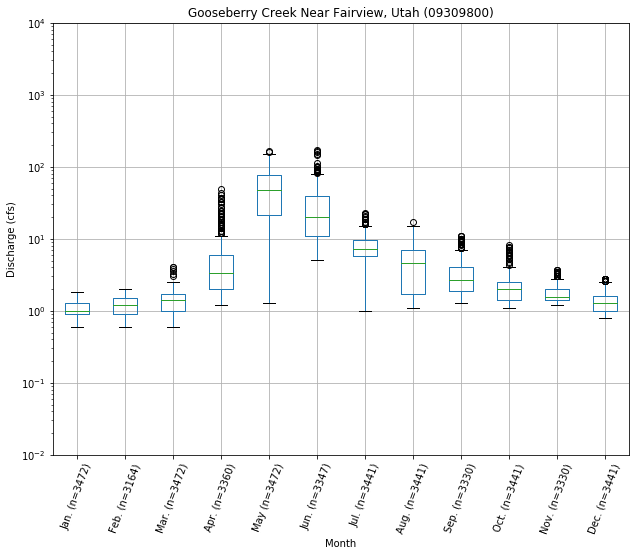

<Figure size 720x576 with 0 Axes>

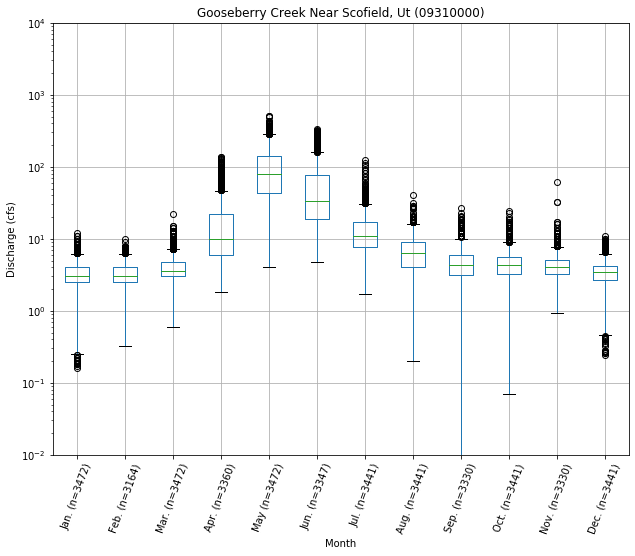

In [20]:
for i in range(1,3):
    j[sites[i]] = USGS_Site_Data.groupby('mon')[sites[i]].agg([np.min, np.mean, np.median, np.max, np.std, np.size]).reset_index()
    # make a list of the custom lables you will use for your boxplot; this one will show the number of samples used to make the plot
    labs = [months[(str(j[sites[i]]['mon'][b]))] + " (n=" + str(int(j[sites[i]]['size'][b])) + ")" for b in range(len(j[sites[i]]))]
    # designate the location of each custom label
    tickloc = [b+1 for b in range(len(j[sites[i]]['mon']))]

    plt.figure()USGS_Site_Info
    USGS_Site_Data.boxplot(column=sites[i],by='mon', rot=70)
    plt.title(USGS_Site_Info.ix[sites[i],'name'].title() + ' (' + sites[i] + ')')
    plt.suptitle('')
    plt.yscale('log')
    plt.ylabel('Discharge (cfs)')
    plt.ylim((ymin,ymax))
    plt.xlabel('Month')
    # here is where your lists for the custom label come into play
    plt.xticks(tickloc, labs)
    plt.show()
    plt.close()

<Figure size 720x576 with 0 Axes>

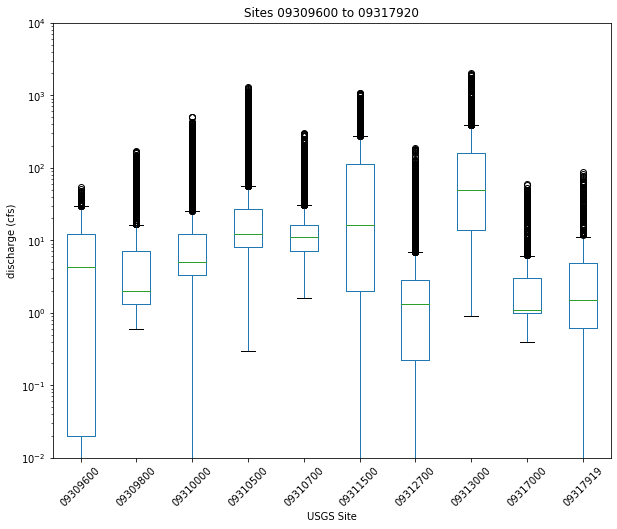

<Figure size 720x576 with 0 Axes>

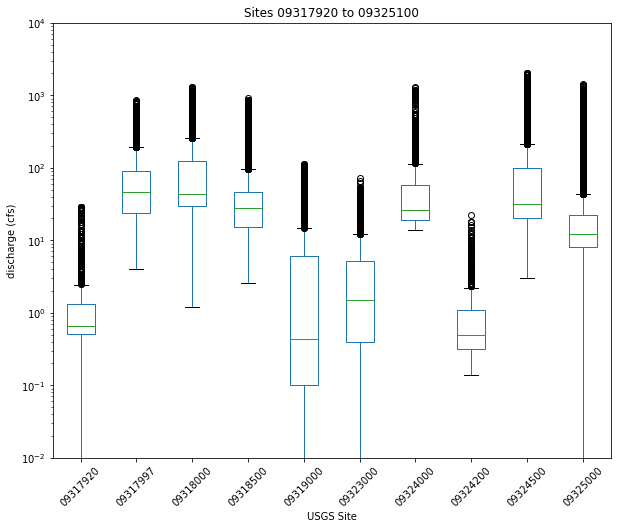

<Figure size 720x576 with 0 Axes>

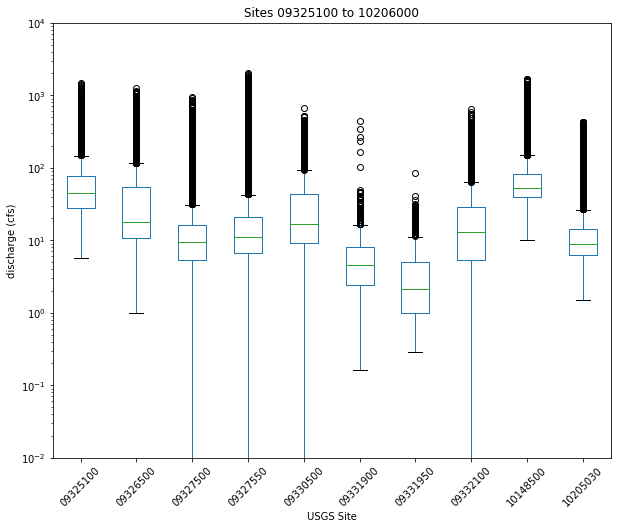

<Figure size 720x576 with 0 Axes>

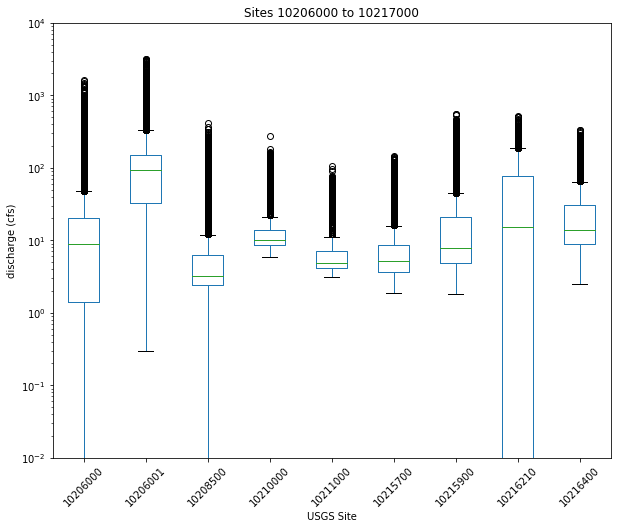

In [21]:
# This script summarizes discharge for all sites and limits the number of box plots on one graph to the n variable
j=0
with PdfPages('sum_boxplots.pdf') as pdf:
    while j < len(sites):
        ymax = 10000
        ymin = 0.01
        n=10
        # if statement allows for uneven number of sites on last page
        if j+n >= len(sites):
            plt.figure()
            USGS_Site_Data[sites[j:-1]].plot(kind='box')
            plt.title('Sites '+sites[j]+' to '+sites[-1] )
            plt.yscale('log')
            plt.xlabel('USGS Site')
            plt.xticks(rotation=45)
            plt.ylabel('discharge (cfs)')
            plt.ylim((ymin,ymax))
            pdf.savefig()
            plt.show()
            plt.close()
            j = j+n
        else:
            plt.figure()
            USGS_Site_Data[sites[j:j+n]].plot(kind='box')
            plt.title('Sites '+sites[j]+' to '+sites[j+n] )
            plt.yscale('log')
            plt.xlabel('USGS Site')
            plt.xticks(rotation=45)
            plt.ylabel('discharge (cfs)')
            plt.ylim((ymin,ymax))
            pdf.savefig()
            plt.show()
            plt.close()
            j = j+n
        # Save metadata of the pdf so you can find it later
        d = pdf.infodict()
        d['Title'] = 'Summary USGS Boxplots UMSS'
        d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
        d['Subject'] = 'Boxplots of several USGS Surface Stations'
        d['Keywords'] = 'USGS Surface NWIS Boxplot'
        d['CreationDate'] = datetime.today()
        d['ModDate'] = datetime.today()

In [25]:
xmax = USGS_Site_Data.index.astype(datetime).values[-1]
xmin = USGS_Site_Data.index.astype(datetime).values[0]

pdfs = PdfPages('station_hydrographs.pdf')
ymax = 10000
ymin = 0.1
for i in range(len(sites)):
    x = USGS_Site_Data.index.values
    y = USGS_Site_Data[sites[i]].values
    plt.figure()
    plt.plot(x,y)
    strtdt = str(USGS_Site_Info.ix[sites[i],'start_date'])[0:10]
    findt = str(USGS_Site_Info.ix[sites[i],'fin_date'])[0:10]
    siteName = USGS_Site_Info.ix[sites[i],'name'].title() 
    plt.title( siteName + ' (' + sites[i] + ')  ' + strtdt + ' to ' + findt )
    plt.suptitle('')
    plt.yscale('log')
    plt.ylabel('Discharge (cfs)')
    plt.ylim((ymin,ymax))
    plt.xlabel('Year')
    plt.xticks(np.arange(datetime(1905,1,1),xmax+timedelta(days=365.25),timedelta(days=365.25*5)),rotation=45)
    plt.xlim(xmin,xmax)
    pdfs.savefig()
    plt.close()
    # Save metadata of the pdf so you can find it later

d = pdfs.infodict()
d['Title'] = 'Monthly Station USGS Hydrographs UMSS'
d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
d['Subject'] = 'Hydrograph of several USGS Surface Stations'
d['Keywords'] = 'USGS Surface NWIS Hydrograph'
d['CreationDate'] = datetime.today()
d['ModDate'] = datetime.today()

TypeError: dtype <class 'datetime.datetime'> not understood

In [26]:
pd.date_range(start=xmin, end=xmax, freq='5AS').year

NameError: name 'xmin' is not defined

In [27]:
n1 = 12
n2 = 11

USGS_Site_Data[sites[n1]+'p'] = [USGS_parms['all_var1'][n1]*np.log(USGS_Site_Data[sites[n1]][i]*USGS_parms['all_var2'][n1]+\
                                                                   USGS_parms['all_var3'][n1])+USGS_parms['all_var4'][n1] for i in \
range(len(USGS_Site_Data[sites[n1]]))]

USGS_Data = USGS_Site_Data[USGS_Site_Data[sites[n1]+'p']>0]

USGS_Data[sites[n2]+'d'] = [USGS_parms['allin_var1'][n2]*np.exp(USGS_Data[sites[n1]+'p'][i]*USGS_parms['allin_var2'][n2]+\
                                                                   USGS_parms['allin_var3'][n2])+USGS_parms['allin_var4'][n2] for i in \
range(len(USGS_Data[sites[n1]+'p']))]

y1 = USGS_Data[sites[n2]+'d'].values
y2 = USGS_Site_Data[sites[n2]].values

x1 = USGS_Data.index.to_datetime()
x2 = USGS_Site_Data.index.to_datetime()
y3 = USGS_Data[sites[n1]]


plt.figure()
plt.plot(x1,y1, label="modeled discharge")
plt.plot(x2,y2, label="actual discharge")
plt.plot(x1,y3, label="reference discharge")
plt.yscale('log')
plt.legend()
#plt.xlim(USGS_Site_Info['start_date'][n2],USGS_Site_Info['fin_date'][n2])
plt.xlim('1/1/1970','1/1/1974')
#plt.ylim(1,100)

NameError: name 'USGS_parms' is not defined

/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


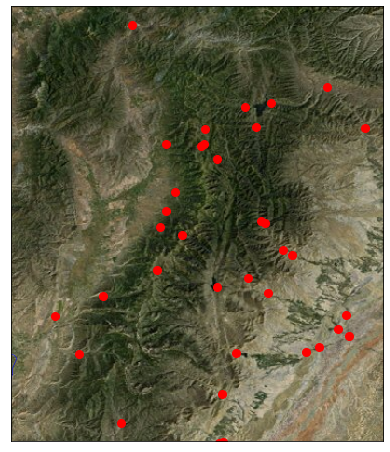

In [32]:
from mpl_toolkits.basemap import Basemap
X = USGS_Site_Info['longitude'].astype(float).values.tolist()
Y = USGS_Site_Info['latitude'].astype(float).values.tolist()

n = 0.05 
m = Basemap(llcrnrlon=min(X)+n,llcrnrlat=min(Y)+n,urcrnrlon=max(X)+n,urcrnrlat=max(Y)+n,
            resolution='h',projection='cyl',lon_0=np.mean(X),lat_0=np.mean(Y))
m.drawrivers(color='blue',linewidth=0.5)
#m.drawcounties(color='red',linewidth=0.5)
m.arcgisimage()
#m.etopo(scale=0.5)
lons = X
lats = Y
x,y = m(lons,lats)
m.plot(x,y,'ro', markersize=8)

#m.drawmapscale(lon=-114, lat=43.5, length=100, lon0=-114, lat0=39, barstyle='simple', units='km')